In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from collections import Counter

In [3]:
df = pd.read_csv('star_classification.csv')
df.drop(['obj_ID'], axis = 1,inplace=True) #dropping OBJ_ID feature as it is just the ID
df.drop(['rerun_ID'], axis = 1,inplace=True)#dropping rerun_ID feature as it is the same for all
df.drop(['run_ID'], axis = 1,inplace=True)
df.drop(['field_ID'], axis = 1,inplace=True)
df.drop(['spec_obj_ID'], axis = 1,inplace=True)
df.drop(['cam_col'], axis = 1,inplace=True)
df

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000,9374,57749,438
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895,7626,56934,866
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366,2764,54535,74
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040,6751,56368,470


In [7]:
data = np.array(df)

In [8]:
#dealing with class labels (changing class strings to 0 1 2):
def label_corrector(array):
    temp = list()
    seen_labels = set()
    dict_of_labels = dict()
    label_counter = -1
    for label in array:
        if label in seen_labels:
            temp.append(dict_of_labels[label])
        else:
            label_counter += 1
            dict_of_labels[label] = label_counter
            seen_labels.add(label)
            temp.append(label_counter)
    return np.array(temp)
            


In [9]:
class_index = 7
data[:,class_index] = label_corrector(data[:,class_index])
train_d = data[:80000]
train_x = np.concatenate((train_d[:,:class_index],train_d[:,class_index+1:]),axis=1)
train_y = train_d[:,class_index]

test_d = data[80000:]
test_x = np.concatenate((test_d[:,:class_index],test_d[:,class_index+1:]),axis=1)
test_y = test_d[:,class_index]

In [10]:
#getting the feature histograms
tdata = np.transpose(train_x) #transposed training matrix
histograms = list()
for col in  tdata:
    hst = np.histogram(col,bins = 100) 
    histograms.append(hst)
    #plt.plot(hst[1][1:],hst[0])
    #plt.show()

In [11]:
#histograms show that there are outliers, to be sure, IQR concept is used to look at outliers:
IQRs = list()
for ind, col in  enumerate(tdata):
    percentiles = np.percentile(col,[25,75]) #calclating 25 and 75 th percentiles
    IQR = percentiles[1]-percentiles[0] #calulating interquartile range
    right = col>(percentiles[1]+1.5*IQR)
    left = col <(percentiles[0]-1.5*IQR)
    outliers = right+left
    print(f"{ind}th feature has {sum(outliers)} outliers.")
    

0th feature has 0 outliers.
1th feature has 0 outliers.
2th feature has 44 outliers.
3th feature has 83 outliers.
4th feature has 109 outliers.
5th feature has 201 outliers.
6th feature has 267 outliers.
7th feature has 7272 outliers.
8th feature has 0 outliers.
9th feature has 0 outliers.
10th feature has 0 outliers.


In [12]:
# Outliers can be removed given that it is not a critical task (serious applications) and there are not many outliers
#9th feature has many outliers, close to 5-10 percent. Hence, only the outliers of 2 3 4 5 6 th features will be removed.

#removing outliers:
IQRs = list()
outlier_rows = np.array([])
for ind, col in  enumerate(tdata):
    if ind in [3,4,5,6,2]:
        percentiles = np.percentile(col,[25,75])
        IQR = percentiles[1]-percentiles[0]
        right = (col>percentiles[1]+1.5*IQR)*1
        left = (col < (percentiles[0]-1.5*IQR))*1
        outliers = right+left
        #print(f"{ind}th feature has {sum(outliers)} outliers.")
        outlier_rows = np.append(outlier_rows,np.where(outliers == 1)[0])
outlier_rows = np.array(list(set(outlier_rows)))
outlier_rows = np.array(outlier_rows,dtype = 'int')
train_x = np.delete(train_x,outlier_rows,axis=0)
train_y = np.delete(train_y,outlier_rows,axis=0)

In [13]:
#Looking at histograms after outliers are removed:
#getting the feature histograms:
tdata = np.transpose(train_x) #transposed training matrix
histograms = list()
for col in  tdata:
    hst = np.histogram(col,bins = 100) 
    histograms.append(hst)
    #plt.plot(hst[1][1:],hst[0])
    #plt.show()

In [14]:
means_x = list()
stds_x = list()

for ind in range(np.shape(train_x)[1]):
    col = train_x[:,ind]
    mean = np.mean(col)
    std = np.std(col)
    means_x.append(mean)
    stds_x.append(std)
    train_x[:,ind] = (col-mean)/std
    

    
    

for ind in range(np.shape(test_x)[1]):
    col = test_x[:,ind]
    test_x[:,ind] = (col-means_x[ind])/stds_x[ind]

    


# Decision Tree Implementation

In [15]:
#This one uses Counter
class Node:
    #The tree is defined with nodes that have nodes in them. The process will be implemented recursively 
    #in later parts.
    
    def __init__(self, depth=None,right_node=None, left_node=None,node_type=None,node_class = None,split_feature = None,split_threshold = None ):
        #The building block of the tree.
        #The tree is a node that have nodes...
        self.left_node = left_node
        self.right_node =right_node
        self.node_type = node_type
        self.node_class = node_class
        self.split_feature = split_feature
        self.split_threshold = split_threshold

class DecisionTree:
    def __init__(self, data=None, labels=None,max_split =500,min_member=5):
        self.max_split=max_split
        self.data = data
        self.labels = labels
        self.min_member=min_member
        
    def get_class(self,labels):
        unique, counts = np.unique(labels, return_counts=True)
        counter = dict(zip(unique, counts))
        return max(labels, key=lambda x: counter[x])

    def run(self,data,labels,split_number):

        #This is the function where the recursion happens: nodes that have nodes.
       
        split_feature,split_threshold,gini = self.get_splitting_point(data,labels) #returns the feature index and the threshold
        if gini > 0 and split_number< self.max_split and len(labels) > self.min_member: #split until spliting conditions are met
            right_data, left_data,right_labels,left_labels = self.get_split(split_feature, split_threshold, data,labels)
            right_node = self.run(data=right_data,labels = right_labels,split_number=split_number+1) 
            left_node = self.run(data = left_data,labels=left_labels,split_number=split_number+1)
            return Node(node_type = "branch",right_node = right_node, left_node = left_node,split_feature=split_feature,split_threshold=split_threshold,depth=split_number  )
        else:
            return Node(node_type = "leaf",node_class = self.get_class(labels))
    def get_splitting_point(self,data,labels):
        num_instances, num_features = np.shape(data)
        gini =np.inf
        for feature in range(num_features):
            split_threshold, gini_gain = self.best_of_feature_split(data,labels,feature)
            if gini_gain<gini:
                gini = gini_gain
                best_split_threshold , best_split_feature = split_threshold,feature
        return best_split_feature,best_split_threshold,gini 
        #return split_feature, split_threshold, gini_gain
    def best_of_feature_split(self,data,labels,split_feature):
        feature_col = data[:,split_feature]
        thresholds = np.unique(feature_col, return_counts=False) #using the values as thresholds to make it efficient
        min_gini = np.inf 
        for threshold in thresholds:
            right_data, left_data,right_labels,left_labels = self.get_split(split_feature,threshold,data,labels)
            len_right = len(right_labels)
            len_left = len(left_labels)
            gini = self.gini_index(right_labels)*(len_right/(len_right+len_left))+self.gini_index(left_labels)*(len_left/(len_right+len_left))
            if gini < min_gini:
                min_gini = gini
                split_threshold = threshold
        return split_threshold, min_gini
    def get_split(self,split_feature,split_threshold,data,labels):
        feature_col = data[:,split_feature]
        pos1 =np.where(feature_col>split_threshold)[0]
        pos2 = np.where(feature_col<=split_threshold)[0]
        right_data = data[pos1]
        left_data=data[pos2]
        left_labels=labels[pos2] 
        right_labels=labels[pos1]  
        return right_data, left_data,right_labels,left_labels   
    def fit(self):
        self.decision_maker = self.run(self.data,self.labels,0) #this returns a node instance 
    def predict(self,new_data):
        predictions = list()
        for row in new_data:
            predictions.append(self.infer(self.decision_maker,row))
        return predictions
            
    def infer(self,node,datapoint):
        if node.node_type == "branch":
            val = datapoint[node.split_feature] 
            if val > node.split_threshold:
                return self.infer(node.right_node,datapoint)
            else:
                return self.infer(node.left_node,datapoint)
        elif node.node_type == "leaf":
                return node.node_class
    def gini_index(self,labels):
        length = len(labels)

        counter = Counter(labels)
        gini = 1
        for val in counter.values():
            gini -= (val/length)**2
        return gini
    


**Training and Inference Time**

In [16]:
Tree = DecisionTree(train_x[:1000],train_y[:1000],max_split =100)

In [17]:
from time import time
t1 = time()
Tree.fit()
print(time()-t1)

7.3924407958984375


In [18]:
predictions = Tree.predict(test_x)

In [19]:
count = 0
for ind,prediction in enumerate(predictions):
    if test_y[ind]==prediction:
        count+=1
print((count/len(predictions))*100)

95.00999999999999


**Evaluation Metrics**

In [16]:
def confusion_matrice(pred,truth,num_of_class):
    """
    Return the confusion matrix where the column indexes are predictions and 
    row indexes are ground truths.
    
    """
    confusion_mtrx=np.zeros((num_of_class,num_of_class),dtype=np.int32)
    for ind,prediction in enumerate(predictions):
        confusion_mtrx[truth[ind]][prediction]+=1
    
    dataframe = pd.DataFrame(data=confusion_mtrx,   index=np.arange(0,num_of_class),   columns=np.arange(0,num_of_class))
    dataframe = dataframe.style.set_caption('The Confusion Matrix ')
    return dataframe
def accuracy(pred,truth):
    count = 0

    for ind,prediction in enumerate(predictions):
        if truth[ind]==prediction:
            count+=1
    accuracy = (count/len(predictions))*100
    return accuracy


In [17]:
print(accuracy(predictions, test_y))
confusion_matrice(predictions, test_y,3)

95.00999999999999


,0,1,2
0,11495,286,78
1,545,3201,1
2,87,1,4306


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

C:\Users\Onat\AppData\Local\Temp/ipykernel_39036/2662250973.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cf_matrix = confusion_matrix(np.array(test_y,dtype=np.int),np.array(predictions))


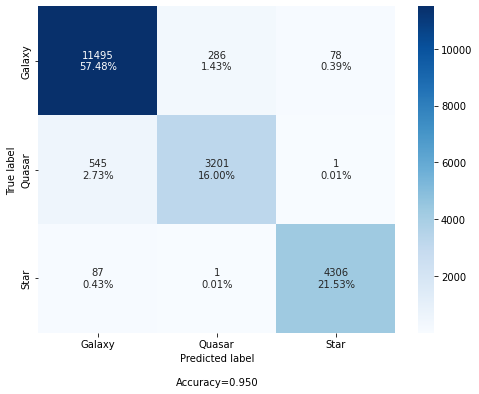

In [20]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(np.array(test_y,dtype=np.int),np.array(predictions))
make_confusion_matrix(cf_matrix,
                          group_names=None,
                          categories=["Galaxy","Quasar","Star"],
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=(8,6), 
                          cmap='Blues',
                          title=None)

 **Performance Analysis**

In [578]:
Tree = DecisionTree(train_x[:1000],train_y[:1000])
from line_profiler import LineProfiler
lp = LineProfiler()
lp.enable_by_count()
lp.add_function(Tree.best_of_feature_split)
lp.add_function(Tree.get_split)
lp.add_function(Tree.get_splitting_point)
lp.add_function(Tree.run)
lp.add_function(Tree.gini_index)
lp_wrapper = lp(Tree.fit)
Tree.fit()
lp.print_stats()

Timer unit: 1e-07 s

Total time: 10.2305 s
File: C:\Users\Onat\AppData\Local\Temp/ipykernel_18724/1133872911.py
Function: build_the_tree at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                               def build_the_tree(self,data,labels,current_depth):
    22        53        277.0      5.2      0.0          try:
    23        53       3304.0     62.3      0.0              num_instances, num_features = np.shape(data)
    24                                                   except ValueError:
    25                                                       return Node(node_type = "leaf",node_class = None)
    26        53  102260790.0 1929448.9    100.0          split_feature,split_threshold,gini = self.get_splitting_point(data,labels) #returns the feature index and the threshold
    27                                                   
    28        53        742.0     14.0      0.0          if gini > 0 and current_depth< self